# Week 3 CNN Cancer Detection Kaggle Mini-Project
Student, University of Colorado Boulder

## Step 1: Brief description of the problem and data

For the week 3 mini project, I will be using machine learning algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.  The problem is a binary image classification problem.

The details are available in Kaggle competition https://www.kaggle.com/c/histopathologic-cancer-detection/overview

I will be using Convolutional Neural Networks (CNN) to process the images and classify them as having metastatic cancer or not having metastatic cancer.  A good model could help physicians in detecting metastatic cancer.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

import cv2
import os
import shutil

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import ResNet50V2

%maplotlib inline

UsageError: Line magic function `%maplotlib` not found.


## Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

#### Data Extraction
User has to register on kaggle to get access to the dataset.  This data is expected to be stored in data/histopathologic-cancer-detection folder

In [4]:
train_labels_df = pd.read_csv('data/histopathologic-cancer-detection/train_labels.csv')
train_labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Let us look at the type and shape of data

In [5]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
train_labels_df.shape

(220025, 2)

Let us check if there are any duplicates and remove if present

In [7]:
train_labels_df['id'].duplicated().any()

False

There are no duplicates.

Let us look at the distribution of the labels

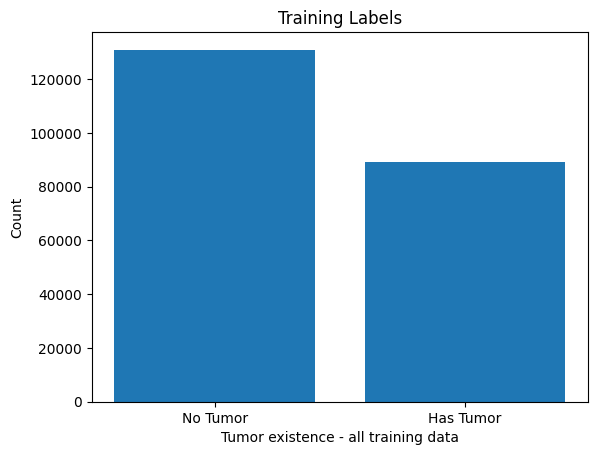

In [8]:
def plot_tumor_existence(df, data_type):
    df['label'].plot.hist()

    x = ["No Tumor", "Has Tumor"]
    y = [df['label'].value_counts()[0.0], df['label'].value_counts()[1.0]]
         
    plt.bar(x, y)
    plt.title("Training Labels")
         
    plt.xlabel(f"Tumor existence - {data_type} data")
    plt.ylabel("Count")
         
    plt.show()

plot_tumor_existence(train_labels_df, 'all training')

In [9]:
def show_images(df, category, directory):
    f,ax = plt.subplots(nrows=1, ncols=4)
    count = 0
    for _,r in df.iterrows():
        if r['label'] == category:
            image_file = directory+r['id']+'.tif'
            image = cv2.imread(image_file)
            ax[count].imshow(image, resample=True, cmap='gray')
            count += 1
        if count > 3:
            break
    plt.tight_layout()
    plt.show()
            

Let us look at a sample of images where the image is labeled as no tumor

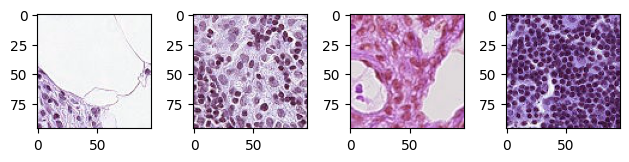

In [10]:
show_images(train_labels_df, 0, 'data/histopathologic-cancer-detection/train/')

Let us look at a sample of images where the image is labeled as has tumor

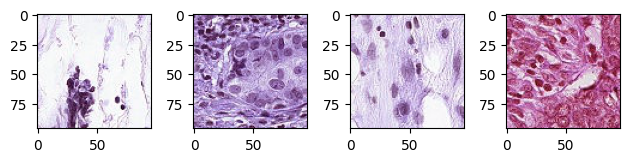

In [11]:
show_images(train_labels_df, 1, 'data/histopathologic-cancer-detection/train/')

Since the data is imbalanced with more negative cases than positive cases, we will consider only random 80000 entries for the first model

In [12]:
entry_count = 80000

df_negative = train_labels_df[train_labels_df['label'] == 0]
df_positive = train_labels_df[train_labels_df['label'] == 1]

df_negative = df_negative.sample(entry_count, random_state=123)
df_positive = df_positive.sample(entry_count, random_state=123)

df_negative.info()
df_positive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 144972 to 179459
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      80000 non-null  object
 1   label   80000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 144436 to 61695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      80000 non-null  object
 1   label   80000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


Now that we have 80000 entries of positive and negative cases, lets combine them and shuffle them into a new dataframe

In [13]:
df_new_data = shuffle(pd.concat([df_negative, df_positive], axis=0).reset_index(drop=True))
df_new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 4029 to 142497
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      160000 non-null  object
 1   label   160000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


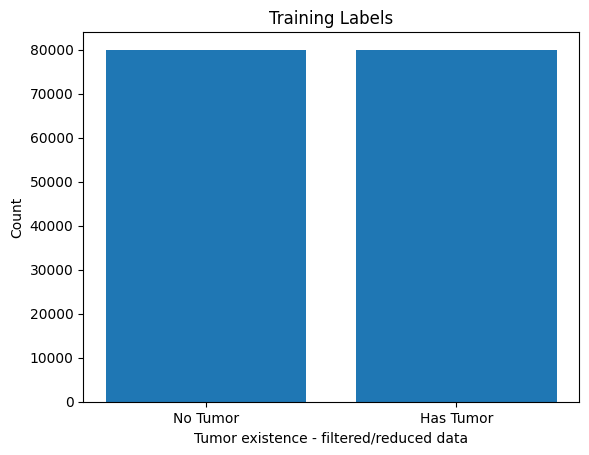

In [14]:
plot_tumor_existence(df_new_data, 'filtered/reduced')

Lets use 80:20 for training and validation with a balanced distribution

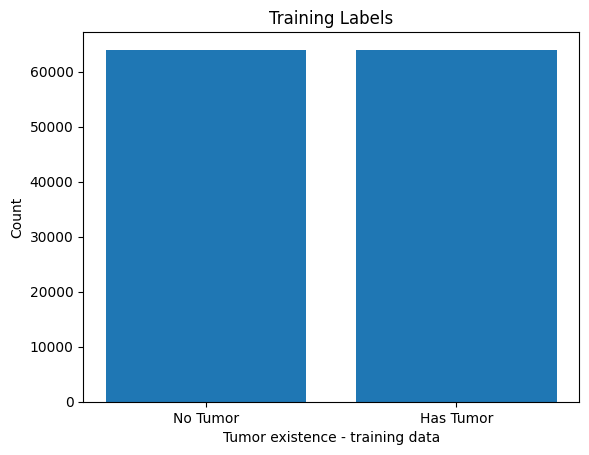

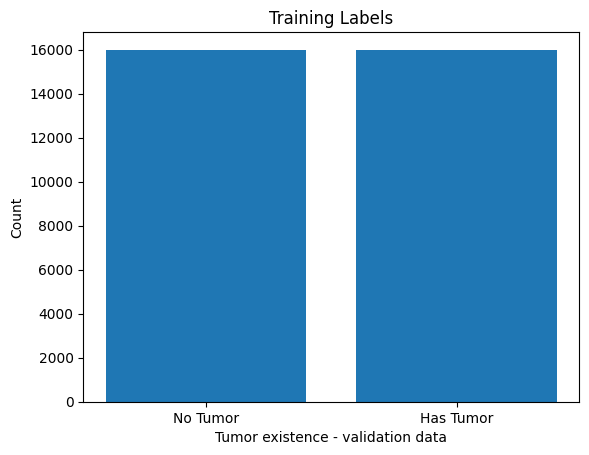

In [15]:
df_train, df_val = train_test_split(df_new_data, test_size=0.2, random_state=123, stratify=df_new_data['label'])

plot_tumor_existence(df_train, "training")
plot_tumor_existence(df_val, "validation")

In [16]:
df_train.head()

,id,label
6610,9e95058fb893e190f7c37981ca39a8acc54324af,0
23078,04d82e035d7d9995385f2f1f49fbc31d90e69dd7,0
108602,1322f75822f0abb9cc04bda0ba1e961106b3ab40,1
8458,a96c9f5ce8fe48a69bf961a397ac79baa2bce059,0
20479,7cf8c1b699629db0b3873cd76a31fd7b2ff69361,0


We verified that the data is shuffled and there is equal distribution of positive and negative cases.

Let us copy the images into 4 folders - training/1, training/0, validation/1, and validation/0 where 0=negative and 1=positive.  Also we change the data frames to contain the path to the images

In [17]:
training_folder = 'training'
validation_folder = 'validation'
positive_folder = '1'
negative_folder = '0'
train_data_path = 'data/histopathologic-cancer-detection/train'
for t in [training_folder, validation_folder]:
    if not os.path.exists(os.path.join(train_data_path, t)):
        os.makedirs(os.path.join(train_data_path, t))
    for p in [positive_folder, negative_folder]:
        if not os.path.exists(os.path.join(train_data_path, t, p)):
            os.makedirs(os.path.join(train_data_path, t, p))

copied = 0
paths = list()
for _, row in df_train.iterrows():
    id = row['id']
    label = row['label']
    src = os.path.join('data/histopathologic-cancer-detection/train', id+ '.tif')
    if label == 0.0:
        dst = os.path.join(train_data_path, training_folder, negative_folder, id+ '.tif')
    else:
        dst = os.path.join(train_data_path, training_folder, positive_folder, id+ '.tif')
    shutil.copyfile(src, dst)
    copied += 1
    paths.append(dst)
df_train['path'] = paths
print(f'copied {copied} files into training folder')

copied = 0
paths = list()
for _, row in df_val.iterrows():
    id = row['id']
    label = row['label']
    src = os.path.join('data/histopathologic-cancer-detection/train', id+ '.tif')
    if label == 0.0:
        dst = os.path.join(train_data_path, validation_folder, negative_folder, id+ '.tif')
    else:
        dst = os.path.join(train_data_path, validation_folder, positive_folder, id+ '.tif')
    shutil.copyfile(src, dst)
    copied += 1
    paths.append(dst)
df_val['path'] = paths
print(f'copied {copied} files into validation folder')

copied 128000 files into training folder
copied 32000 files into validation folder


In [18]:
training_image_dg = ImageDataGenerator(rescale=1./255., rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

train_flow = training_image_dg.flow_from_dataframe(dataframe = df_train,
                                              x_col = 'path', y_col ='label',
                                              target_size = (224,224), batch_size = 32, class_mode='raw',
                                              shuffle = True)
val_flow = training_image_dg.flow_from_dataframe(dataframe=df_val, 
                                            target_size=(224,224), x_col = 'path', y_col ='label', class_mode='raw',
                                            batch_size= 16, shuffle=True)

Found 128000 validated image filenames.
Found 32000 validated image filenames.


Now let us do the same steps for test data

In [19]:
test_images_path = 'data/histopathologic-cancer-detection/test'
ids = list()
paths = list()
for _,_, file_names in os.walk(test_images_path):
    for file_name in file_names:
        ids.append(file_name.replace('.tif', ''))
        paths.append(os.path.join(test_images_path, file_name))

df_test = pd.DataFrame({'id':ids, 'path':paths})
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   path    57458 non-null  object
dtypes: object(2)
memory usage: 897.9+ KB


In [20]:
df_test.describe()

,id,path
count,57458,57458
unique,57458,57458
top,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,data/histopathologic-cancer-detection/test/fd0...
freq,1,1


In [22]:
df_test.head()

,id,path
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,data/histopathologic-cancer-detection/test/fd0...
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,data/histopathologic-cancer-detection/test/1f9...
2,19709bec800f372d0b1d085da6933dd3ef108846,data/histopathologic-cancer-detection/test/197...
3,7a34fc34523063f13f0617f7518a0330f6187bd3,data/histopathologic-cancer-detection/test/7a3...
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,data/histopathologic-cancer-detection/test/93b...


In [24]:
test_flow = training_image_dg.flow_from_dataframe(dataframe=df_test,
                                              x_col='path', y_col=None,
                                              target_size=(224,224), batch_size=32, class_mode=None,
                                              shuffle=True)


Found 57458 validated image filenames.


## Step 3: Model Architecture

I will use ResNet50V2 model that is pre-trained on ImageNet to see how it performs on our data

In [50]:
# Load weights pre-trained on ImageNet.
base_model = ResNet50V2(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [55]:
callbacks = [
    ModelCheckpoint("cnn_classifier_model.keras", save_best_only=True, verbose = 0),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001),
    EarlyStopping(monitor='val_accuracy', min_delta=0.0002, patience=5, mode='max', verbose=1, restore_best_weights=True)
]

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])

history = model.fit(train_flow, validation_data = val_flow, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100


/Users/kkuruvad/Desktop/masters/UniversityOfColoradoBoulder/DTSA 5511 Introduction to Deep Learning/week3/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2904s 725ms/step - accuracy: 0.7341 - loss: 0.5271 - val_accuracy: 0.8194 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 2/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2900s 725ms/step - accuracy: 0.8099 - loss: 0.4144 - val_accuracy: 0.8268 - val_loss: 0.3874 - learning_rate: 1.0000e-04
Epoch 3/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2904s 726ms/step - accuracy: 0.8167 - loss: 0.4034 - val_accuracy: 0.8324 - val_loss: 0.3769 - learning_rate: 1.0000e-04
Epoch 4/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2912s 728ms/step - accuracy: 0.8188 - loss: 0.4000 - val_accuracy: 0.8341 - val_loss: 0.3755 - learning_rate: 1.0000e-04
Epoch 5/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2950s 737ms/step - accuracy: 0.8211 - loss: 0.3948 - val_accuracy: 0.8355 - val_loss: 0.3721 - learning_rate: 1.0000e-04
Epoch 6/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2968s 742ms/step - accuracy: 0.8215 - loss: 0.3947 - val_accuracy: 0.8382 - val_loss: 0.3717 - learning_rate: 1.0000e-04
Epoch 7/100
4000/4000 ━━━━━━

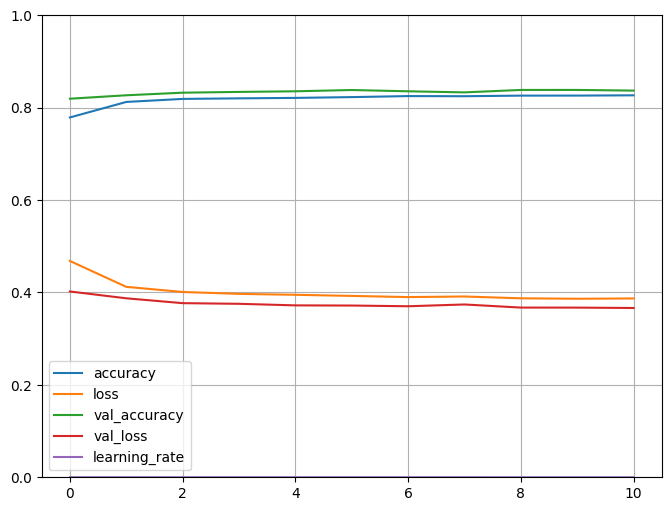

In [58]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [50]:
loaded_model = tf.keras.models.load_model("cnn_classifier_model.keras")

results = loaded_model.predict(test_flow)
result_labels = np.round(results).astype(int)

output = pd.DataFrame({'id':df_test['id']})
output['label'] = result_labels
print(f'shape: {output.shape}')
output.head()
output.to_csv('ResNet50V2.csv', index=False)


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1002s 557ms/step
shape: (57458, 2)


Though the validation results were good enough with ~80+% accuracy, the results were bad on the test data.  It seems like the imagenet weights are not finetuned for this data.  I could add more layers and retry to get a better test result
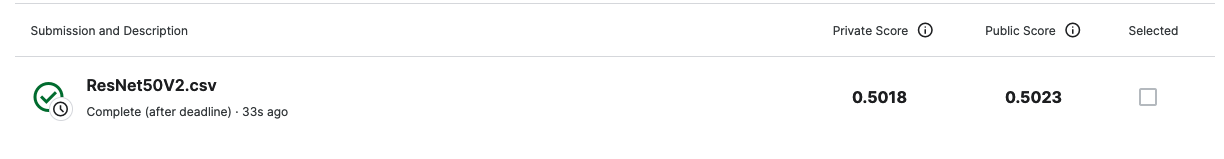

Let me build a model from scratch and see how that performs on the test data
Changes would be to also limit targets to 96x96 and split of 70:30 for training and validation. I will start with epoch 3 and if it is promising, retry with a bigger epoch

In [43]:
base_dp = 'data/histopathologic-cancer-detection'
train_label_path = os.path.join(base_dp, 'train_labels.csv')

train_labels = pd.read_csv(train_label_path)
train_labels['path'] = base_dp + '/train/'+train_labels['id']+'.tif'
train_labels['label'] = train_labels['label'].astype(str)
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_labels,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=train_labels,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

ids = [file[:-4] for file in os.listdir(os.path.join(base_dp, 'test'))]
files = [os.path.join(base_dp, 'test',file) for file in os.listdir(os.path.join(base_dp, 'test'))]

test_dataframe = pd.DataFrame({'id':ids, 'file':files})

test_generator = datagenerator.flow_from_dataframe(
    dataframe=test_dataframe,
    x_col='file',
    y_col=None,
    target_size=(96, 96),
    color_mode='rgb',
    batch_size=32,
    shuffle=False,
    class_mode=None
)

Found 154018 validated image filenames belonging to 2 classes.
Found 66007 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


I will start with a few sets of Conv2D+BatchNormalization+MaxPooling2D layers

In [44]:
second_model = Sequential()
second_model.add(Conv2D(96, (3, 3), activation='relu', input_shape=(96, 96, 3)))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D((2, 2)))

second_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D((2, 2)))

second_model.add(Conv2D(32, (3, 3), activation='relu'))
second_model.add(BatchNormalization())
second_model.add(MaxPooling2D((2, 2)))

second_model.add(Conv2D(16, (3, 3), activation='relu'))
second_model.add(Flatten())
second_model.add(Dense(256, activation='relu'))
second_model.add(Dense(1, activation='sigmoid'))

second_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

history_second_model = second_model.fit(train_generator, validation_data=validation_generator, epochs=3)

test_pred = second_model.predict(test_generator)
output = pd.DataFrame({'id':df_test['id']})
output['label'] = test_pred
print(f'shape: {output.shape}')
output.to_csv('second_model.csv', index=False)

/Users/kkuruvad/Desktop/masters/UniversityOfColoradoBoulder/DTSA 5511 Introduction to Deep Learning/week3/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3


/Users/kkuruvad/Desktop/masters/UniversityOfColoradoBoulder/DTSA 5511 Introduction to Deep Learning/week3/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1060s 220ms/step - accuracy: 0.8225 - auc: 0.8888 - loss: 0.4070 - val_accuracy: 0.8159 - val_auc: 0.9201 - val_loss: 0.4491
Epoch 2/3
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1031s 214ms/step - accuracy: 0.8816 - auc: 0.9454 - loss: 0.2897 - val_accuracy: 0.8508 - val_auc: 0.9083 - val_loss: 0.4674
Epoch 3/3
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1020s 212ms/step - accuracy: 0.9052 - auc: 0.9623 - loss: 0.2393 - val_accuracy: 0.8526 - val_auc: 0.9441 - val_loss: 0.3390
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step
shape: (57458, 2)


This model has better accuracy than the previous model. It scored better as well on the test results
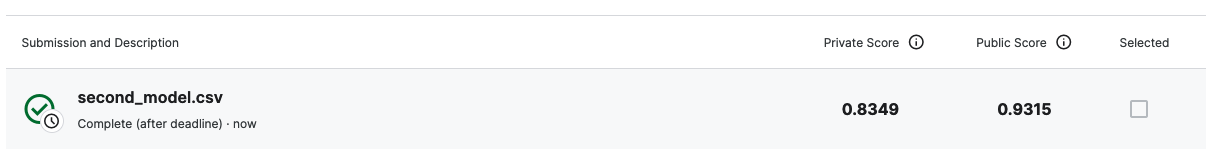

In [51]:
second_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 94, 94, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 94, 94, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 47, 47, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,032,917 (3.94 MB)

 Trainable params: 344,177 (1.31 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 688,356 (2.63 MB)

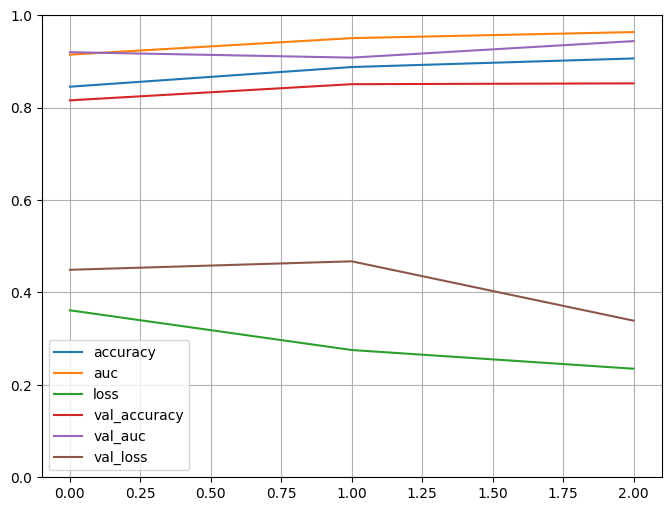

In [48]:
pd.DataFrame(history_second_model.history).plot(figsize=(8, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

This model seems to be performing well.  I will let it run until the val_accuracy peaks and see how better it can get

In [45]:
third_model = Sequential()
third_model.add(Conv2D(96, (3, 3), activation='relu', input_shape=(96, 96, 3)))
third_model.add(BatchNormalization())
third_model.add(MaxPooling2D((2, 2)))

third_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
third_model.add(BatchNormalization())
third_model.add(MaxPooling2D((2, 2)))

third_model.add(Conv2D(32, (3, 3), activation='relu'))
third_model.add(BatchNormalization())
third_model.add(MaxPooling2D((2, 2)))

third_model.add(Conv2D(16, (3, 3), activation='relu'))
third_model.add(Flatten())
third_model.add(Dense(256, activation='relu'))
third_model.add(Dense(1, activation='sigmoid'))

third_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

callbacks = [
    ModelCheckpoint("second_model.keras", save_best_only=True, verbose = 0),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001),
    EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=3, mode='max', verbose=1, restore_best_weights=True)
]

history_third_model = third_model.fit(train_generator, validation_data=validation_generator, epochs=50, 
                    callbacks = [callbacks], verbose = 1)

test_pred = third_model.predict(test_generator)
output = pd.DataFrame({'id':df_test['id']})
output['label'] = test_pred
print(f'shape: {output.shape}')
output.to_csv('third_model.csv', index=False)

/Users/kkuruvad/Desktop/masters/UniversityOfColoradoBoulder/DTSA 5511 Introduction to Deep Learning/week3/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1072s 222ms/step - accuracy: 0.8262 - auc: 0.8905 - loss: 0.4068 - val_accuracy: 0.8052 - val_auc: 0.8942 - val_loss: 0.4608 - learning_rate: 0.0010
Epoch 2/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1081s 224ms/step - accuracy: 0.8839 - auc: 0.9469 - loss: 0.2853 - val_accuracy: 0.8395 - val_auc: 0.9053 - val_loss: 0.4062 - learning_rate: 0.0010
Epoch 3/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1025s 213ms/step - accuracy: 0.9038 - auc: 0.9608 - loss: 0.2432 - val_accuracy: 0.8196 - val_auc: 0.9346 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 4/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1029s 214ms/step - accuracy: 0.9151 - auc: 0.9682 - loss: 0.2184 - val_accuracy: 0.9189 - val_auc: 0.9703 - val_loss: 0.2144 - learning_rate: 0.0010
Epoch 5/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1037s 215ms/step - accuracy: 0.9215 - auc: 0.9729 - loss: 0.2015 - val_accuracy: 0.8955 - val_auc: 0.9638 - val_loss: 0.2604 - learning_rate: 0.0010
Epoch 6/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 0s 

This model scored well both on validation as well as test
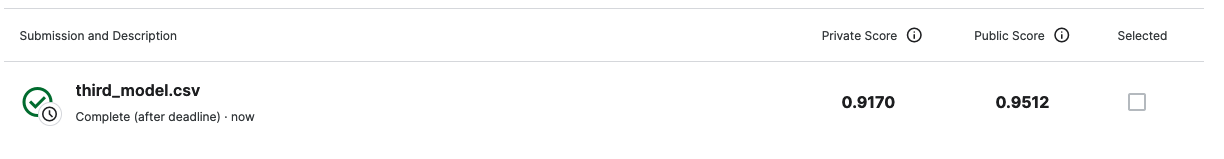

In [52]:
third_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 94, 94, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 94, 94, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 47, 47, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 45, 45, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,032,917 (3.94 MB)

 Trainable params: 344,177 (1.31 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 688,356 (2.63 MB)

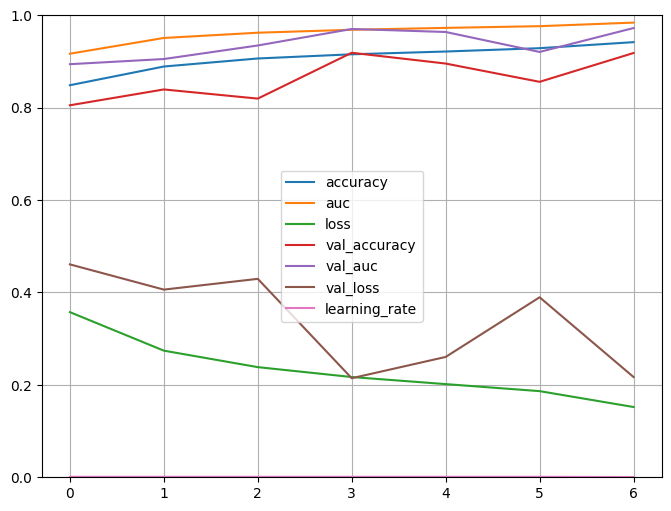

In [49]:
pd.DataFrame(history_third_model.history).plot(figsize=(8, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Let us try a final model by adding one more set of layers

In [47]:
final_model = Sequential()

final_model.add(Conv2D(96, (3, 3), activation='relu', input_shape=(96, 96, 3)))
final_model.add(BatchNormalization())
final_model.add(MaxPooling2D((2, 2)))

final_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 3)))
final_model.add(BatchNormalization())
final_model.add(MaxPooling2D((2, 2)))

final_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
final_model.add(BatchNormalization())
final_model.add(MaxPooling2D((2, 2)))

final_model.add(Conv2D(32, (3, 3), activation='relu'))
final_model.add(BatchNormalization())
final_model.add(MaxPooling2D((2, 2)))

final_model.add(Conv2D(16, (3, 3), activation='relu'))
final_model.add(Flatten())
final_model.add(Dense(256, activation='relu'))
final_model.add(Dense(1, activation='sigmoid'))


final_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

callbacks = [
    ModelCheckpoint("second_model.keras", save_best_only=True, verbose = 0),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001),
    EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=3, mode='max', verbose=1, restore_best_weights=True)
]

history_final_model = final_model.fit(train_generator, validation_data=validation_generator, epochs=50, 
                    callbacks = [callbacks], verbose=1)

test_pred = final_model.predict(test_generator)
output = pd.DataFrame({'id':df_test['id']})
output['label'] = test_pred
print(f'shape: {output.shape}')
output.to_csv('final_model.csv', index=False)

/Users/kkuruvad/Desktop/masters/UniversityOfColoradoBoulder/DTSA 5511 Introduction to Deep Learning/week3/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1035s 215ms/step - accuracy: 0.8238 - auc: 0.8947 - loss: 0.3955 - val_accuracy: 0.8241 - val_auc: 0.9172 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 2/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1035s 215ms/step - accuracy: 0.8850 - auc: 0.9477 - loss: 0.2827 - val_accuracy: 0.7701 - val_auc: 0.8126 - val_loss: 0.6114 - learning_rate: 0.0010
Epoch 3/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1047s 217ms/step - accuracy: 0.9061 - auc: 0.9629 - loss: 0.2373 - val_accuracy: 0.8586 - val_auc: 0.9592 - val_loss: 0.3558 - learning_rate: 0.0010
Epoch 4/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 1052s 219ms/step - accuracy: 0.9168 - auc: 0.9707 - loss: 0.2101 - val_accuracy: 0.7815 - val_auc: 0.8427 - val_loss: 0.7437 - learning_rate: 0.0010
Epoch 5/50
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9216 - auc: 0.9734 - loss: 0.1999
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 14847s 3s/step - accuracy: 0

This model is trained well, worked fine with validation and gives a much better test score than the first model.  But it took longer to train and its results are a little less than the previous model.
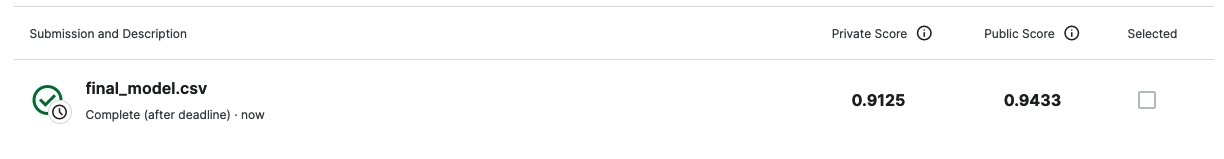

In [53]:
final_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 94, 94, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 94, 94, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 47, 47, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 45, 45, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 20, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 2, 2, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,637 (1.23 MB)

 Trainable params: 107,729 (420.82 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 215,460 (841.64 KB)

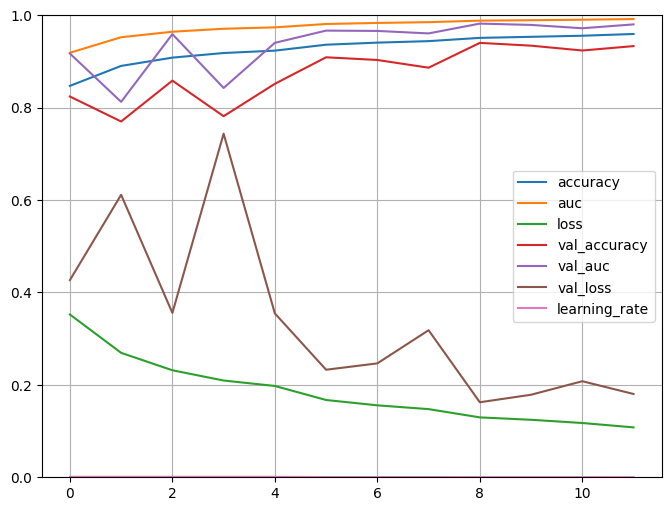

In [54]:
pd.DataFrame(history_final_model.history).plot(figsize=(8, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Step 4: Results and Analysis

I have tried multiple models and different hyperparameters with some yielding good results overall.  A summary of the models and their performance is given below
| model | accuracy| epoch | auc | loss | val_accuracy | val_auc | val_loss | kaggle private score | kaggle public score |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  ResNet50V2  |  0.8215  | 6 |  -   |  0.3947   |  0.8382  |  -   |  0.3717 | 0.5018 | 0.5023 |
|  second_model  |  0.9052  |3| 0.9623 |  0.2393   |  0.8526   |  0.9441  |  0.3390   | 0.8349 | 0.9315 |
|  third_model  |  0.9151  | 4|  0.9682   |  0.2184   |  0.9189  |  0.9703    |  0.2144 | 0.9170 | 0.9512 |
|  final_model  |  0.9509   |  9   |  0.9882   |  0.1311   |  0.9402   |  0.9820   | 0.1624 | 0.9125 | 0.9433 |



The third model was the best among the models that I have tried and it provided the best Kaggle score.  The final model seems to have a little overfitting since it has better statistics than the third model but has slightly lower score on Kaggle.

## Step 5: Conclusion

After using transfer and hand written models, it seems like a general algorithm may or may not provide the best outcomes.  The change I did may not have been enough to suit this requirement.  Having a better knowledge of data might help in forming better performing models.  Training time is a big problem unless we have GPUs at disposal.



## Step 6: Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard

Jupyter notebook: https://github.com/krishnakuruvadi/week3_CNN/blob/main/week3.ipynb

Jupyter report: https://github.com/krishnakuruvadi/week3_CNN/tree/main

Github repository: https://github.com/krishnakuruvadi/week3_CNN/tree/main

Leaderboard:
Unfortunately Kaggle is not showing my position in leaderboard so I am not able to provide the same

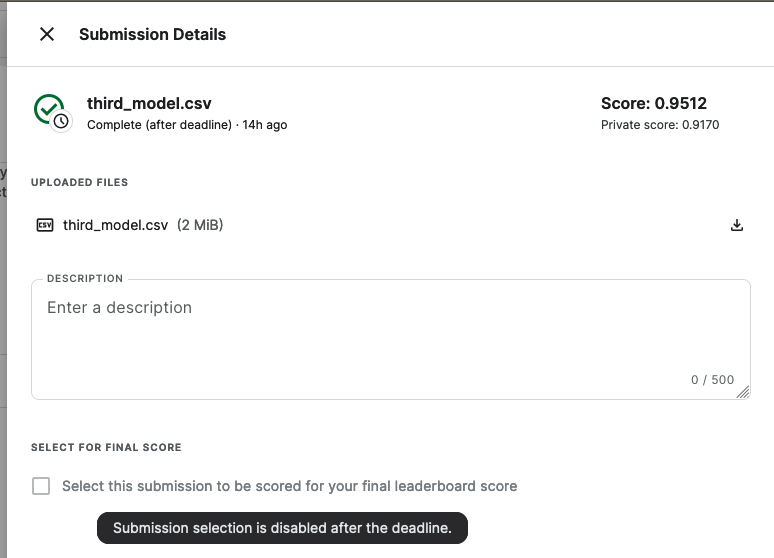

Scores for all models I have tried:
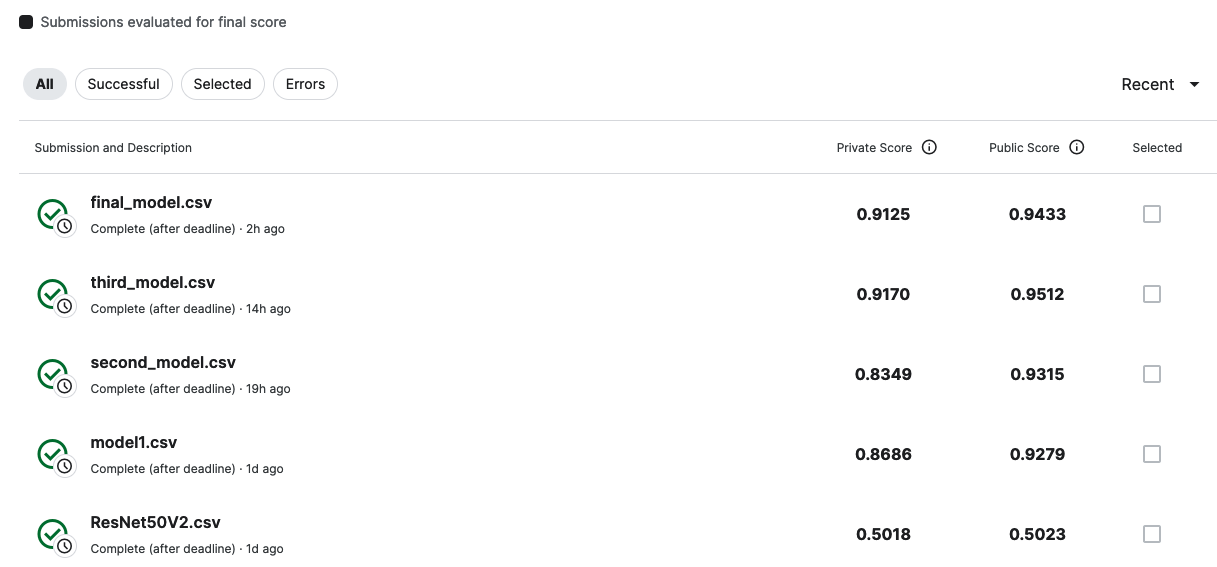

#### References
* ResNet50V2: https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50V2